In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="darkgrid")

In [2]:
df_odi = pd.read_csv('ODI-2022.csv',delimiter=";")

### Number of records

In [3]:
print(len(df_odi.index))

304


### Number of attributes

In [4]:
print(len(df_odi.columns))

17


### Attributes are
    

In [5]:
print((df_odi.columns))

Index(['Tijdstempel', 'What programme are you in?',
       'Have you taken a course on machine learning?',
       'Have you taken a course on information retrieval?',
       'Have you taken a course on statistics?',
       'Have you taken a course on databases?', 'What is your gender?',
       'Chocolate makes you.....', 'When is your birthday (date)?',
       'Number of neighbors sitting around you?', 'Did you stand up?',
       'What is your stress level (0-100)?',
       'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ',
       'Give a random number', 'Time you went to be Yesterday',
       'What makes a good day for you (1)?',
       'What makes a good day for you (2)?'],
      dtype='object')


### Replace columns name

In [6]:
 df_odi.columns = ['time',\
                   'program',\
                   'ML',\
                   'IR',\
                   'Statistics',\
                   'DB',\
                   'Gender',\
               'Chocolate_influence',\
                   'Birthday',\
                   'neighbors',\
                   'Stand_Up',\
                   'Stress',\
              'Euros_Question',\
                   'random_number',\
                   'time_to_bed',\
                   'good_day_1',\
                   'good_day_2']

### Gender distribution

Gender
female                   102
gender fluid               6
intersex                   1
male                     183
not willing to answer     12
Name: Gender, dtype: int64

<AxesSubplot:ylabel='Gender'>

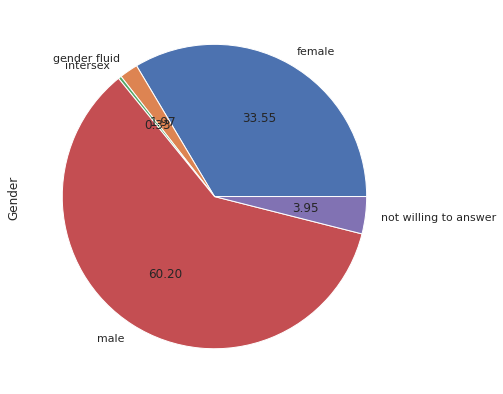

In [16]:
display(df_odi.groupby('Gender')['Gender'].count())
df_odi.groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
#mask = (df_odi['Gender']!='male') & (df_odi['Gender']!='female')
#df_odi['Gender'].loc[mask]

### Random number

In [8]:
display(df_odi['random_number'])


0                        888
1                         12
2                          9
3                         31
4                         86
               ...          
299                        6
300                        0
301                      123
302                        7
303    789458455584851844184
Name: random_number, Length: 304, dtype: object

### Distribution of gender who has entred random numbers noise

In [9]:
def my_convert_to_number(x):
    try:
        return float(x)
    except:
        return None 


df_odi['random_number_'] = df_odi['random_number'].map(my_convert_to_number)
display(df_odi[['Stress','random_number','Gender','Chocolate_influence','time_to_bed']].loc[df_odi['random_number_'].isna()])


,Stress,random_number,Gender,Chocolate_influence,time_to_bed
95,Over 9000,Π,gender fluid,I have no idea what you are talking about,Ω
108,10,1947271047294720^10204847,not willing to answer,neither,23:30
120,Next question,No,male,fat,Dizzy Miss Lizzy was a terrible song to end He...
135,75,"7,66789E+13",male,fat,11:45
141,-69,omega,gender fluid,slim,4:15
168,40,e,male,fat,01:00
187,70,54.727.163.638.182.600.000.000.000.000.000.000...,male,I have no idea what you are talking about,23:00
211,102,"9,13747E+12",gender fluid,I have no idea what you are talking about,To be or not to be?
228,33,sqrt(687458.9665),male,I have no idea what you are talking about,10
236,10,"6,96788E+14",male,unknown,5:00 PM


### Pie chart of Gender put None as random number - no rule obeing 

Text(0.5, 1.0, 'gender distribution for correct data in random number')

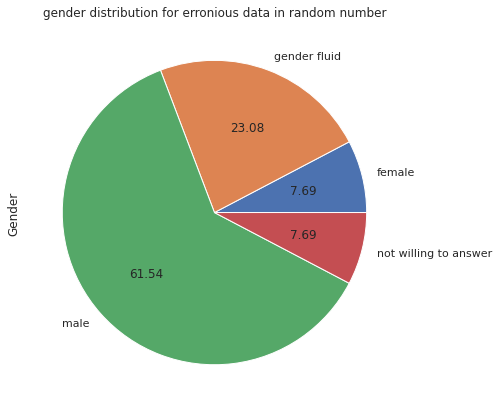

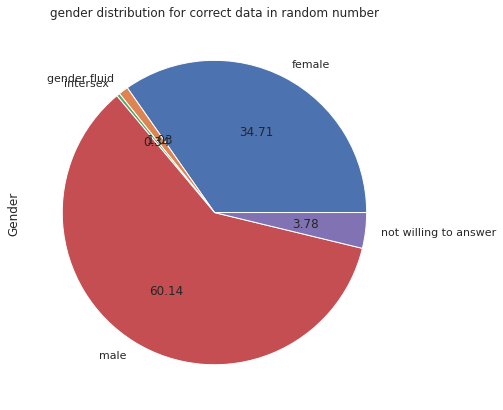

In [11]:
plt.figure(1)
df_odi[['Gender']].loc[df_odi['random_number_'] .isna()].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for erronious data in random number')

plt.figure(2)
df_odi[['Gender']].loc[df_odi['random_number_'] .isna()==False].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for correct data in random number')


### Good day distribution

In [ ]:
from wordcloud import WordCloud
from collections import Counter
dictionary=Counter(df_odi['good_day_2'])

cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from wordcloud import WordCloud
from collections import Counter
dictionary=Counter(df_odi['good_day_1'])

cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()